# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from metaspace.sm_annotation_utils import SMInstance
import getpass
sm_inst = SMInstance(host='https://staging.metaspace2020.eu')
sm_inst

Unauthorized. Only public but not private datasets will be accessible.


SMInstance(https://staging.metaspace2020.eu/graphql)

# Fetch Search Results

In [3]:
# ds_id = '2018-10-16_16h42m00s'
ds_name = 'Testing MS Staging_LK_CMC+LN2_N2_50um'
fdr = 0.2
moldb_name = 'HMDB-v4'
ds = sm_inst.dataset(name=ds_name)
ds

SMDataset(Testing MS Staging_LK_CMC+LN2_N2_50um | ID: 2018-10-31_21h18m02s)

In [4]:
len(ds.annotations(fdr=fdr))

465

In [5]:
%%time
ds_images = ds.all_annotation_images(fdr=fdr, database=moldb_name)
len(ds_images)

CPU times: user 28.6 s, sys: 2.12 s, total: 30.7 s
Wall time: 18.8 s


In [8]:
ann_docs = []
for img in ds_images:
    formula = img._sf
    adduct = img._adduct
    ann_docs.append({
        'formula': formula,
        'adduct': adduct,
        'image': next(iter(img)),
        'image_url': img._urls[0],
    })
len(ann_docs)

465

In [9]:
ann_docs[0]

{'formula': 'C40H80NO8P',
 'adduct': '+H',
 'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'image_url': '/fs/iso_images/55762b493c4168fade2bc6ffdc63592f'}

# Fetch Off-sample Predictions

It's temp solution as this data should be accessible through GraphQL

In [47]:
import json
import getpass

from sm.engine.db import DB

In [48]:
config_path = '/opt/dev/metaspace/metaspace/engine/conf/config.json'
sm_config = json.load(open(config_path))

In [49]:
sm_config['db'] = {
    'host': 'staging.metaspace2020.eu',
    'database': 'sm',
    'user': 'sm',
    'password': '***'
}
password = getpass.getpass(prompt='Password: ', stream=None)
sm_config['db']['password'] = password

Password: ········


In [50]:
moldb = ds._gqclient.get_molecular_databases(names=['HMDB-v4'])[0]
moldb

{'id': 22, 'name': 'HMDB-v4', 'version': '2018-04-09'}

In [51]:
db = DB(sm_config['db'])

rows = db.select_with_fields(
    ('select m.id, sf, adduct, iso_image_ids, off_sample '
     'from iso_image_metrics as m '
     'join job as j on j.id = m.job_id '
     'where j.ds_id = %s and j.db_id = %s and fdr < %s + 0.001'),
    params=(ds.id, moldb['id'], fdr)
)
db.close()

In [52]:
off_sample_preds = {(r['sf'], r['adduct']): r['off_sample'] for r in rows}
len(off_sample_preds), len(ds_images)

(465, 465)

In [53]:
for ann in ann_docs:
    pred = off_sample_preds[(ann['formula'], ann['adduct'])]
    ann.update(pred)

In [54]:
ann_docs[0]

{'formula': 'C40H80NO8P',
 'adduct': '+H',
 'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'image_url': '/fs/iso_images/55762b493c4168fade2bc6ffdc63592f',
 'prob': 0.00018205959349870682,
 'label': 'on'}

# Visualize and Compare

In [55]:
def plot_images(images, labels, limit=20, coln=4):
    limit = min(limit, len(images))
    rown = (limit - 1) // coln + 1

    fig, axes = plt.subplots(rown, coln, figsize=(5*coln, 5*rown))
    for i in range(rown):
        for j in range(coln):
            idx = i * coln + j
            if idx < limit:
                ax = axes[i, j] if axes.ndim > 1 else axes[j]
                ax.imshow(images[idx], cmap='viridis');
                ax.set_title(labels[idx])
    plt.show()

In [56]:
def ann_to_images_labels(anns):
    images = [d['image'] for d in anns]
    
    labels = []
    for d in anns:
        label = d['label']
        prob = d['prob'] if label == 'off' else 1 - d['prob']
        formula, adduct = d['formula'], d['adduct']
        labels.append(f'{formula} {adduct}\nlabel: {label}, prob: {prob:.3f}')
    
    return images, labels

In [57]:
off_ann_docs = [d for d in ann_docs if d['prob'] > 0.5]
len(off_ann_docs)

97

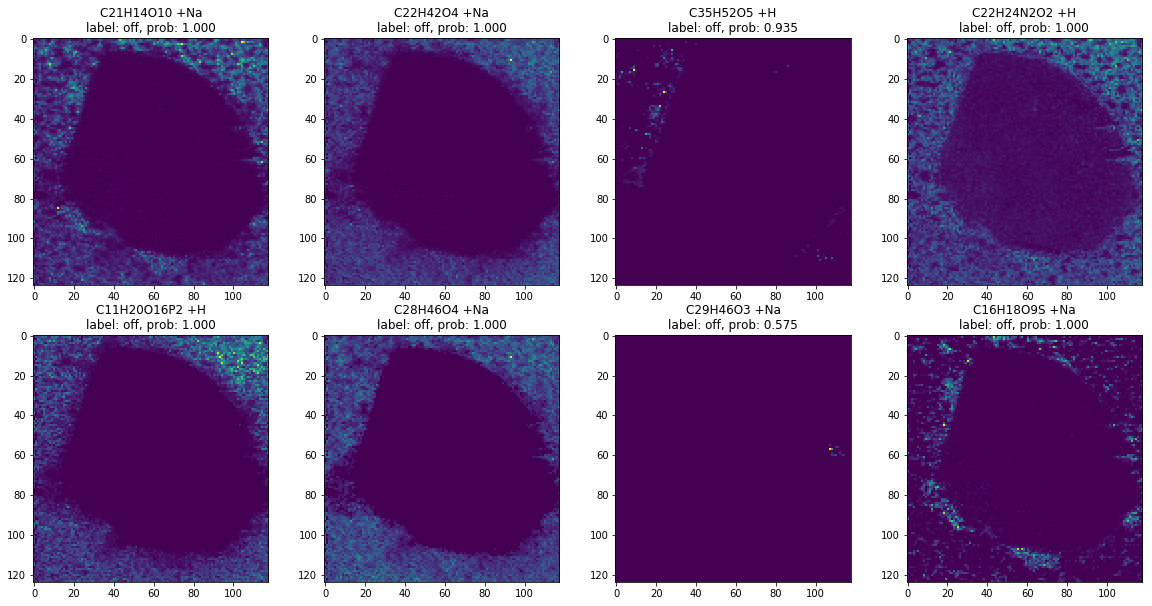

In [58]:
images, labels = ann_to_images_labels(off_ann_docs)
plot_images(images, labels, limit=8)

In [59]:
on_ann_docs = [d for d in ann_docs if d['prob'] < 0.5]
len(on_ann_docs)

368

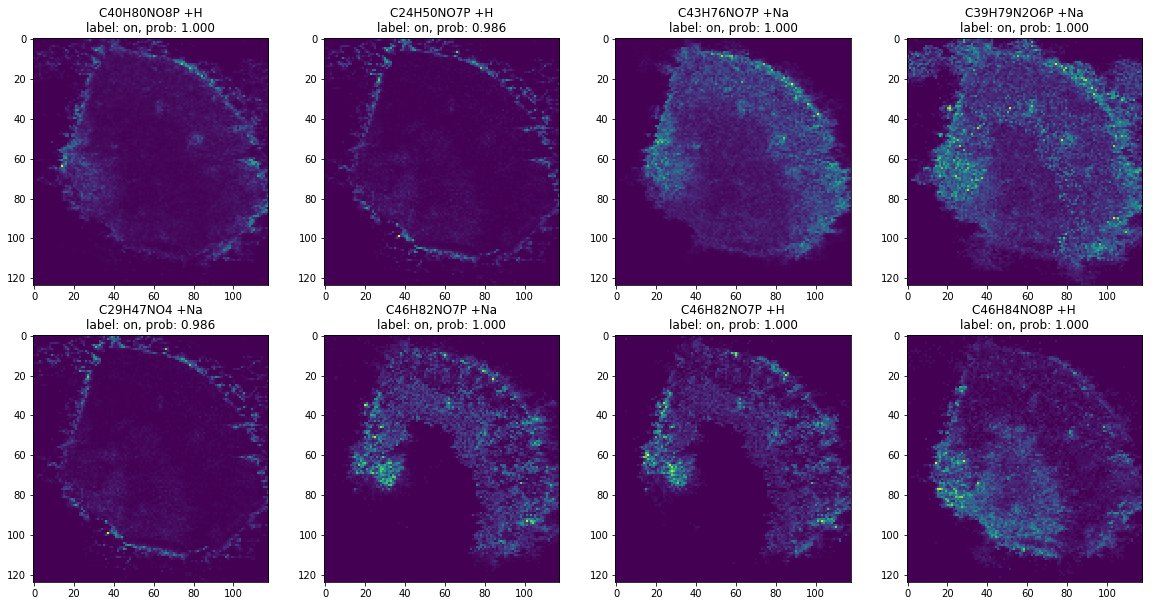

In [60]:
images, labels = ann_to_images_labels(on_ann_docs)
plot_images(images, labels, limit=8)

In [63]:
border_ann_docs = [d for d in ann_docs if 0.4 < d['prob'] < 0.6]
len(border_ann_docs)

18

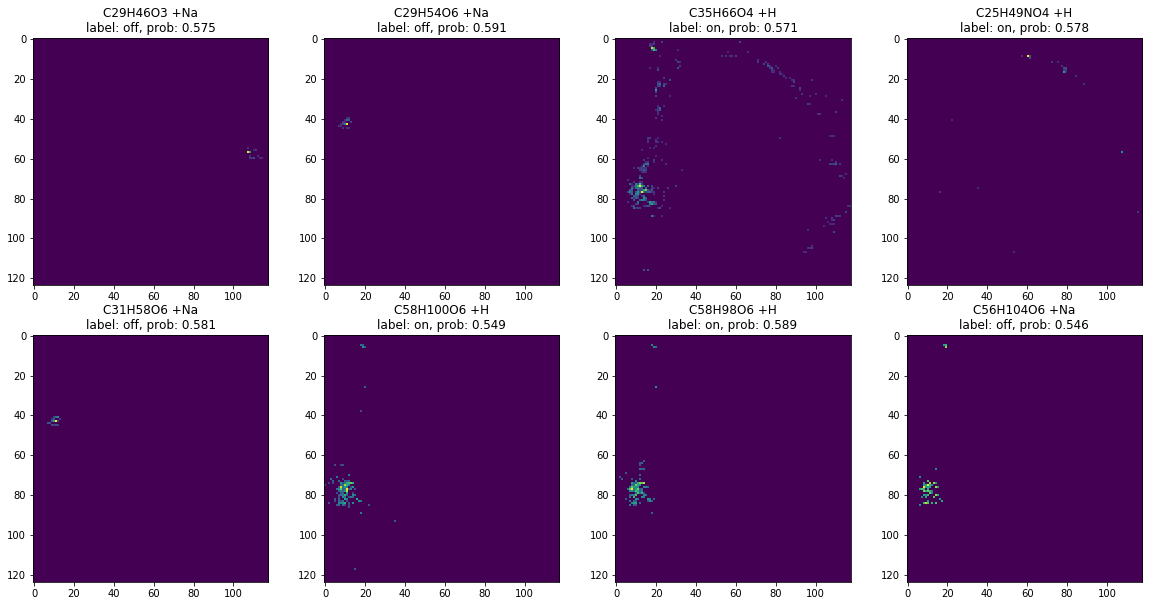

In [64]:
images, labels = ann_to_images_labels(border_ann_docs)
plot_images(images, labels, limit=8)

# Call Off-Sample Service

In [65]:
from PIL import Image
import numpy as np

In [66]:
from sm.engine.off_sample_wrapper import make_classify_images, numpy_to_pil

In [67]:
images = [d['image'] for d in ann_docs]
len(images)

465

In [68]:
type(images[0]), images[0].shape

(numpy.ndarray, (124, 118))

In [41]:
api_endpoint = 'http://off-sample-api-load-balancer-630496755.eu-west-1.elb.amazonaws.com/off-sample'
classify_images = make_classify_images(api_endpoint, numpy_to_pil)

In [42]:
%%time
preds = classify_images(images)

CPU times: user 642 ms, sys: 120 ms, total: 761 ms
Wall time: 25.7 s


In [34]:
len(preds)

465

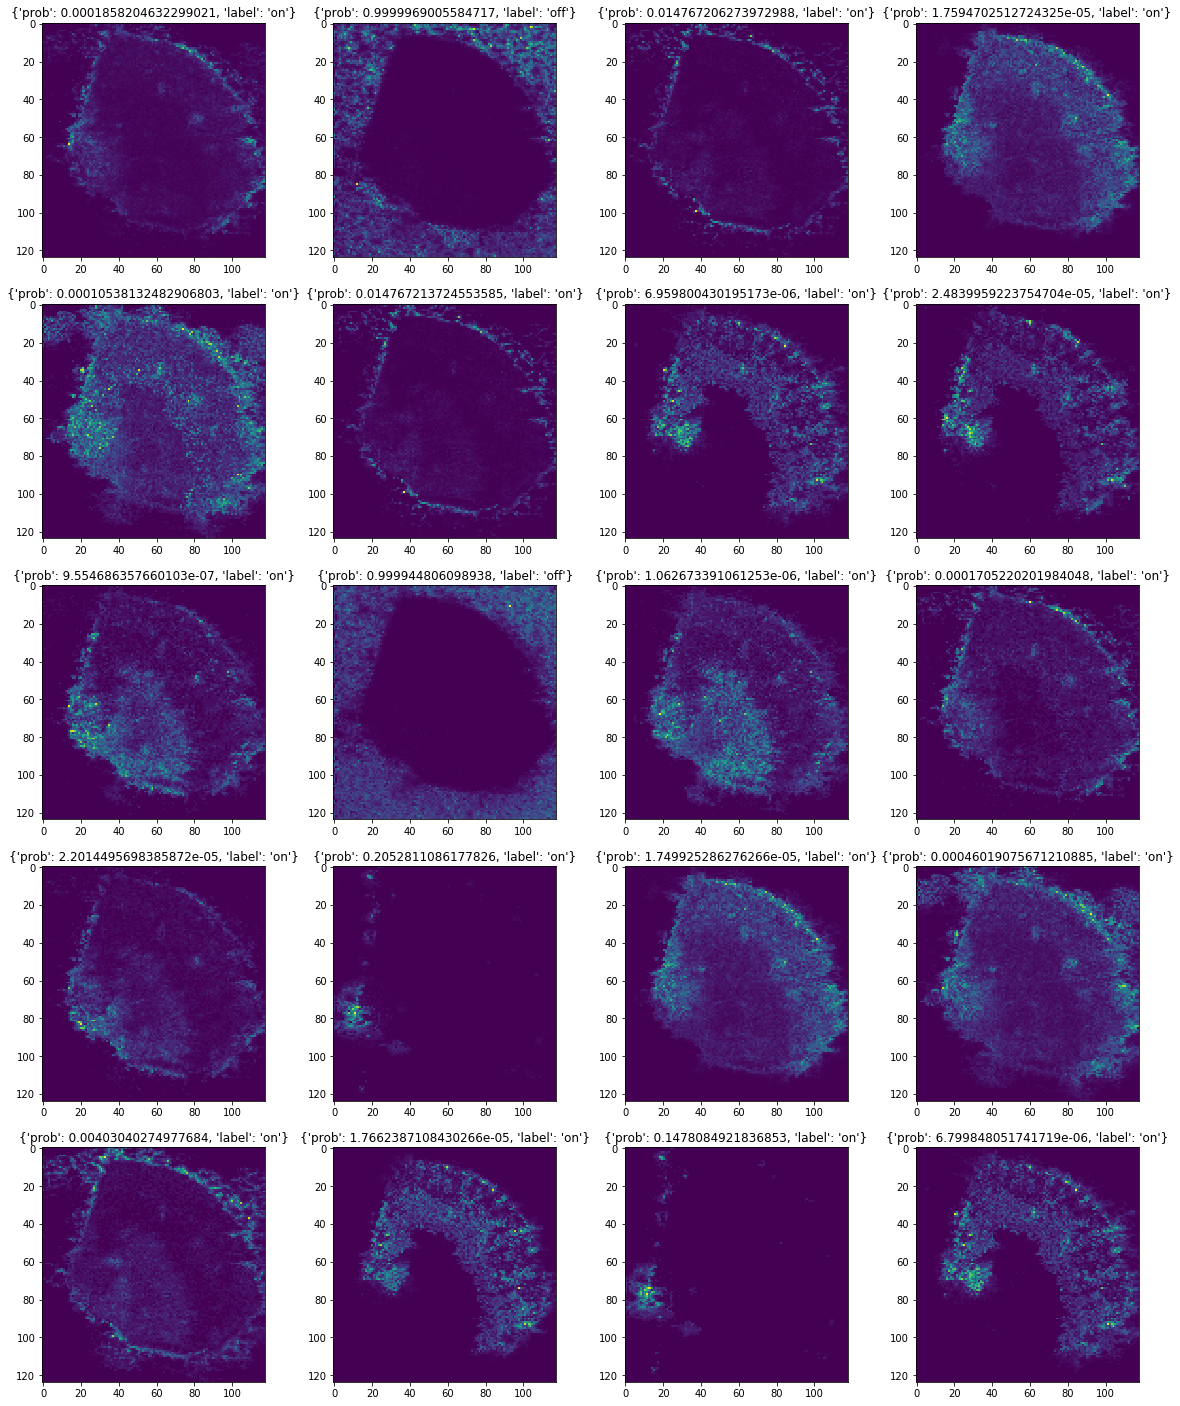

In [37]:
plot_images(images, preds)

In [225]:
for ann, pred in zip(off_ann_docs, preds):
    print(ann['formula'], ann['adduct'], ann['prob'], pred['prob'])

C21H14O10 +Na 0.9999969005584717 0.9999969005584717
C22H42O4 +Na 0.9999465942382812 0.999944806098938
C35H52O5 +H 0.9351113438606262 0.9351049661636353
C22H24N2O2 +H 0.9999994039535522 0.9999994039535522
C11H20O16P2 +H 0.9999650716781616 0.9999651908874512
C28H46O4 +Na 0.9998337030410767 0.9998302459716797
C29H46O3 +Na 0.5751572251319885 0.5739261507987976
C16H18O9S +Na 0.999920129776001 0.9999184608459473
C27H20O21S +H 0.9999932050704956 0.9999932050704956
C10H16N4O7S +H 0.8139786124229431 0.8139786124229431
C35H52O6 +H 0.9322258234024048 0.9321801662445068
